In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import argparse

import tensorflow as tf
from tensorflow.keras import layers, Model

import sklearn.metrics
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../'); sys.path.append('../..')
import utils

seed = 314159

2023-04-05 22:32:07.846896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:32:08.054079: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-05 22:32:08.655518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/loomis/apps/avx/software/cuDNN/8.1.1.33-CUDA-11.2.2/lib:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/nvvm/lib64:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/extras/CUPTI/lib64:/gpfs/loomis/apps/

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import wandb
wandb.login()

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

wandb_project_name = 'dev_abstracter_sorting_generalization'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


In [4]:
def create_callbacks(monitor='loss'):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

# from seq2seq_transformer import TeacherForcingAccuracy
# teacher_forcing_acc_metric = TeacherForcingAccuracy(ignore_class=None)
# metrics = [teacher_forcing_acc_metric]
metrics = [tf.keras.metrics.sparse_categorical_accuracy]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None, name='sparse_categorical_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

fit_kwargs = {'epochs': 200, 'batch_size': 128}


## Dataset and Utils

In [5]:
# NOTE: update
# region evaluation code
def evaluate_argsort_model(model, source_test, labels_test, print_=False):
    
    preds = argsort_model(source_test)
    preds = np.argmax(preds, axis=-1)

    seq_acc = np.mean(np.all(preds == labels_test, axis=-1))
    elementwise_acc = np.mean(preds==labels_test)

    acc_per_position = [np.mean(preds[:, i] == labels_test[:, i]) for i in range(seqs_length)]
    
    if print_:
        print('element-wise accuracy: %.2f%%' % (100*elementwise_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))


    return_dict = {
        'elementwise_accuracy': elementwise_acc,
        'full_sequence_accuracy': seq_acc,
        'acc_by_position': acc_per_position
        }

    return return_dict

def log_to_wandb(model, evaluation_dict):
    acc_by_position_table = wandb.Table(
        data=[(i, acc) for i, acc in enumerate(evaluation_dict['acc_by_position'])], 
        columns=["position", "element-wise accuracy at position"])

    evaluation_dict['acc_by_position'] = wandb.plot.line(
        acc_by_position_table, "position", "element-wise accuracy at position",
        title="Element-wise Accuracy By Position")

    wandb.log(evaluation_dict)

In [6]:
eval_task_data = np.load('object_sorting_datasets/task2_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, argsort_labels, start_token = (eval_task_data['objects'], eval_task_data['seqs'], eval_task_data['sorted_seqs'], eval_task_data['object_seqs'], \
    eval_task_data['target'], eval_task_data['labels'], eval_task_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, argsort_labels, test_size=test_size, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

_, seqs_length, object_dim = object_seqs.shape # NOTE: replace

source_train, source_val, source_test = object_seqs_train, object_seqs_val, object_seqs_test

In [7]:
# NOTE: change/replace

common_args = dict(
    num_layers=4, num_heads=8, dff=64, 
    output_dim=seqs_length, embedding_dim=64, 
    dropout_rate=0.1)
transformer_kwargs = rel_abstractor_kwargs = common_args

In [8]:
# NOTE: add
from transformer_modules import AddPositionalEmbedding, Encoder
from abstracters import RelationalAbstracter

## Task 1: Transformer

In [9]:
# NOTE: add/change
def create_model(embedding_dim, num_layers, num_heads, dff, dropout_rate, output_dim):
    source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
    final_layer = layers.Dense(output_dim, name='final_layer')

    inputs = layers.Input(shape=(seqs_length, object_dim))
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = final_layer(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='transformer')

    opt = create_opt()
    model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
    return model


In [10]:
argsort_model = create_model(**transformer_kwargs)
argsort_model.summary()

2023-04-05 22:32:22.741453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:32:23.424743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14624 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 source_embedder (TimeDistri  (None, 10, 64)           576       
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  (None, 10, 64)           0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           (None, 10, 64)            564992    
                                                                 
 final_layer (Dense)         (None, 10, 10)            650       
                                                                 
Total params: 566,218
Trainable params: 566,218
Non-tra

In [11]:
train_size = 10000 # len(seqs_train)
X_train = object_seqs_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
 7/79 [=>............................] - ETA: 1s - loss: 2.5848 - sparse_categorical_accuracy: 0.1041 

2023-04-05 22:32:28.252019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


79/79 [==============================] - 6s 36ms/step - loss: 2.3445 - sparse_categorical_accuracy: 0.1024 - val_loss: 2.3015 - val_sparse_categorical_accuracy: 0.1084
Epoch 2/100
79/79 [==============================] - 2s 27ms/step - loss: 2.3035 - sparse_categorical_accuracy: 0.1051 - val_loss: 2.3003 - val_sparse_categorical_accuracy: 0.1131
Epoch 3/100
79/79 [==============================] - 2s 28ms/step - loss: 2.3002 - sparse_categorical_accuracy: 0.1140 - val_loss: 2.2994 - val_sparse_categorical_accuracy: 0.1136
Epoch 4/100
79/79 [==============================] - 2s 27ms/step - loss: 2.2986 - sparse_categorical_accuracy: 0.1161 - val_loss: 2.2984 - val_sparse_categorical_accuracy: 0.1174
Epoch 5/100
79/79 [==============================] - 2s 28ms/step - loss: 2.2971 - sparse_categorical_accuracy: 0.1207 - val_loss: 2.2979 - val_sparse_categorical_accuracy: 0.1191
Epoch 6/100
79/79 [==============================] - 2s 27ms/step - loss: 2.2964 - sparse_categorical_accuracy: 

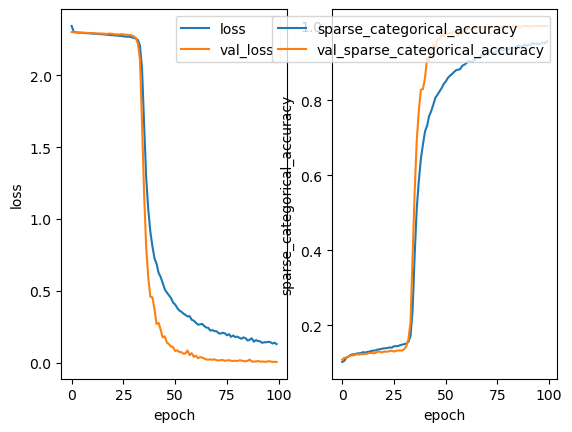

In [12]:
utils.plot_history(history, ('loss', 'sparse_categorical_accuracy'));

In [13]:
eval_dict = evaluate_argsort_model(argsort_model, X_train, y_train, 
    print_=True)

element-wise accuracy: 99.94%
full sequence accuracy: 99.54%


In [14]:
eval_dict = evaluate_argsort_model(argsort_model, object_seqs_test, labels_test, 
    print_=True)

element-wise accuracy: 99.87%
full sequence accuracy: 99.07%


## Task 1: Relational Abstractor

$$(x_1, ..., x_m) \to \texttt{Abstractor} \to (y_1, ..., y_m)$$

Note: no encoder!

In [44]:
# NOTE: add/change
def create_model(embedding_dim, num_layers, num_heads, dff, dropout_rate, output_dim):

    embedder = tf.keras.Sequential([layers.Dense(32, activation='relu'), layers.Dense(16)])
    source_embedder = layers.TimeDistributed(embedder, name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    encoder = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstractor')
    final_layer = layers.Dense(output_dim, name='final_layer')

    inputs = layers.Input(shape=(seqs_length, object_dim))
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = final_layer(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='abstractor')

    opt = create_opt()
    model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
    return model


In [45]:
argsort_model = create_model(**rel_abstractor_kwargs)
argsort_model.summary()

Model: "abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 source_embedder (TimeDistri  (None, 10, 16)           816       
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  (None, 10, 16)           0         
 dPositionalEmbedding)                                           
                                                                 
 abstractor (RelationalAbstr  (None, 10, 16)           77792     
 acter)                                                          
                                                                 
 final_layer (Dense)         (None, 10, 10)            170       
                                                        

In [19]:
train_size = 10000 # len(seqs_train)
X_train = object_seqs_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
79/79 [==============================] - 8s 48ms/step - loss: 2.3385 - sparse_categorical_accuracy: 0.1001 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.0997
Epoch 2/100
79/79 [==============================] - 3s 37ms/step - loss: 2.3040 - sparse_categorical_accuracy: 0.1020 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.0998
Epoch 3/100
79/79 [==============================] - 3s 37ms/step - loss: 2.3032 - sparse_categorical_accuracy: 0.1011 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1003
Epoch 4/100
79/79 [==============================] - 3s 37ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1004
Epoch 5/100
79/79 [==============================] - 3s 37ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.1013 - val_loss: 2.3028 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/100
79/79 [==============================] - 3s 37ms/step - loss: 2.3030 - sparse_categorica

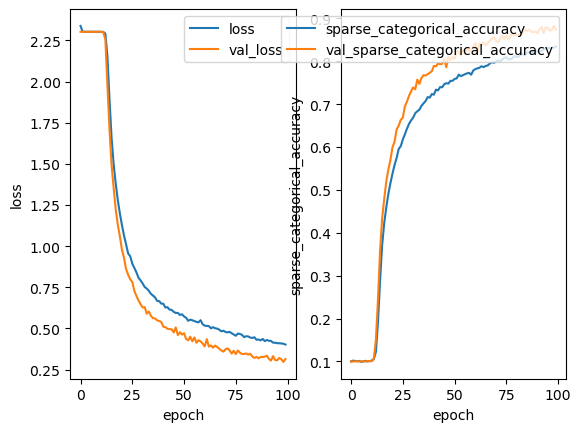

In [20]:
utils.plot_history(history, ('loss', 'sparse_categorical_accuracy'));

In [21]:
eval_dict = evaluate_argsort_model(argsort_model, X_train, y_train, 
    print_=True)

element-wise accuracy: 91.67%
full sequence accuracy: 45.60%


In [22]:
eval_dict = evaluate_argsort_model(argsort_model, object_seqs_test, labels_test, 
    print_=True)

element-wise accuracy: 87.34%
full sequence accuracy: 30.74%


## Task 1: Relational Abstractor (w Encoder)

$$(x_1, ..., x_m) \to \texttt{Encoder} \to \texttt{Abstractor} \to (y_1, ..., y_m)$$


In [30]:
# NOTE: add/change
def create_model(embedding_dim, num_layers, num_heads, dff, dropout_rate, output_dim):

    source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
    pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
    encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
    abstractor = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstractor')
    final_layer = layers.Dense(output_dim, name='final_layer')

    inputs = layers.Input(shape=(seqs_length, object_dim))
    x = source_embedder(inputs)
    x = pos_embedding_adder_input(x)
    x = encoder(x)
    x = abstractor(x)
    x = final_layer(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='abstractor')

    opt = create_opt()
    model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
    return model


In [31]:
argsort_model = create_model(**rel_abstractor_kwargs)
argsort_model.summary()

Model: "abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 source_embedder (TimeDistri  (None, 10, 64)           576       
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  (None, 10, 64)           0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           (None, 10, 64)            564992    
                                                                 
 abstractor (RelationalAbstr  (None, 10, 64)           1096832   
 acter)                                                          
                                                        

In [32]:
train_size = 10000 # len(seqs_train)
X_train = object_seqs_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val
y_val = labels_val

# run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128)#, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/100
79/79 [==============================] - 12s 74ms/step - loss: 2.3669 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/100
79/79 [==============================] - 4s 57ms/step - loss: 2.3051 - sparse_categorical_accuracy: 0.0993 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0993
Epoch 3/100
79/79 [==============================] - 4s 56ms/step - loss: 2.3033 - sparse_categorical_accuracy: 0.0994 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0997
Epoch 4/100
79/79 [==============================] - 4s 56ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.1018 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1004
Epoch 5/100
79/79 [==============================] - 4s 56ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0993
Epoch 6/100
79/79 [==============================] - 4s 56ms/step - loss: 2.3028 - sparse_categoric

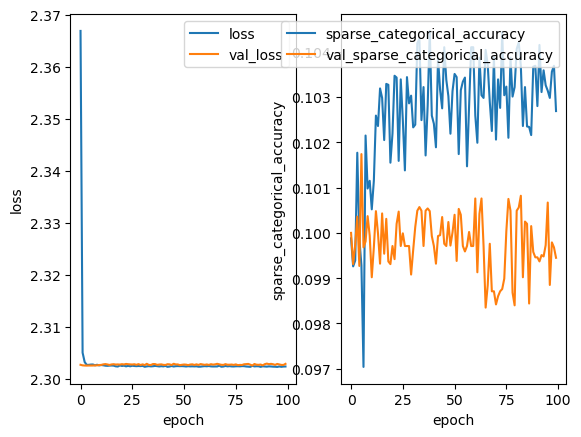

In [33]:
utils.plot_history(history, ('loss', 'sparse_categorical_accuracy'));

In [40]:
eval_dict = evaluate_argsort_model(argsort_model, X_train, y_train, 
    print_=True)

element-wise accuracy: 10.40%
full sequence accuracy: 0.00%


In [39]:
eval_dict = evaluate_argsort_model(argsort_model, object_seqs_test, labels_test, 
    print_=True)

element-wise accuracy: 9.97%
full sequence accuracy: 0.00%


In [51]:
argsort_model.get_layer('source_embedder').trainable = False
argsort_model.get_layer('abstractor').trainable = False

In [54]:
argsort_model.summary()

Model: "abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 source_embedder (TimeDistri  (None, 10, 16)           816       
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  (None, 10, 16)           0         
 dPositionalEmbedding)                                           
                                                                 
 abstractor (RelationalAbstr  (None, 10, 16)           77792     
 acter)                                                          
                                                                 
 final_layer (Dense)         (None, 10, 10)            170       
                                                        

In [59]:
max(history.epoch)

99

In [62]:
argsort_model.fit?

Signature:
argsort_model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targ

In [64]:
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=100, batch_size=128, initial_epoch=max(history.epoch)+1)

In [60]:
for layer in argsort_model.layers:
    layer.trainable = True